In [1]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as RectPatch

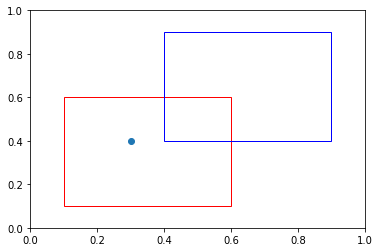

In [2]:
class Rectangle:
    def __init__(self, x0, x1, y0, y1):
        self.lower = np.array([x0, y0])
        self.higher = np.array([x1, y1])
        
    def inside(self, x, y):
        point = np.array([x, y])
        return ((self.lower <= point) * (point <= self.higher)).sum().item() == 2
    
    def plot(self, ax, edgecolor = 'blue'):
        dim = self.higher - self.lower
        ax.add_patch(RectPatch((self.lower[0], self.lower[1]), dim[0], dim[1], fill = False, edgecolor = edgecolor))
    
rect0 = Rectangle(0.1, 0.6, 0.1, 0.6)
rect1 = Rectangle(0.4, 0.9, 0.4, 0.9)

def draw_rectangles(ax, rect0, rect1):
    plt.axis([0., 1., 0., 1.])
    rect0.plot(ax, 'red')
    rect1.plot(ax)

fig, ax = plt.subplots()
ax.scatter([0.3], [0.4])
draw_rectangles(ax, rect0, rect1)
plt.show()

In [3]:
class RectanglesDataset(Dataset):
    def __init__(self, count, r0, r1):
        super(RectanglesDataset, self).__init__()
        self.r0 = r0
        self.r1 = r1

        self.values = [torch.rand((2,)) for i in range(count)]
        self.labels = [self.correct(x, y) for (x, y) in self.values]

    def correct(self, x, y):
        small = self.r0.inside(x, y)
        big = small or self.r1.inside(x, y)
        return torch.tensor([float(small), float(big)])

    def __len__(self):
        return len(self.values)  

    def __getitem__(self, index):
        return self.values[index], self.labels[index]

In [4]:
points = 10000
train_data = RectanglesDataset(points, rect0, rect1)
test_data = RectanglesDataset(points // 10, rect0, rect1)

train_dataloader = DataLoader(train_data, batch_size = 64)
test_dataloader = DataLoader(test_data, batch_size = 64)

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(2, 4),
            nn.Tanh(),
            nn.Linear(4, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear(x)
        return x

base = NeuralNetwork()
print(base)

NeuralNetwork(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): Sigmoid()
  )
)


In [6]:
class Constraint:
    def __init__(self, pos, neg, head):
        self.pos = pos
        self.neg = neg
        self.head = head
    
    def apply_as_positive(self, input):
        inputs, atoms = input.shape
        pos_body = input[:, self.pos]
        neg_body = 1 - input[:, self.neg]
        body = torch.cat((pos_body, neg_body), dim=1).min(dim=1).values
        head = input[:, self.head]
        return torch.maximum(body, head)
    
    def apply_as_negative(self, input, guide):
        inputs, atoms = input.shape
        pos_body = torch.where(guide[:, self.pos] == 0., input[:, self.pos], torch.ones_like(input[:, self.pos]))
        neg_body = torch.where(guide[:, self.neg] == 1., 1 - input[:, self.neg], torch.ones_like(input[:, self.neg]))
        body = torch.cat((pos_body, neg_body), dim=1).min(dim=1).values
        head = input[:, self.head]
        return torch.maximum(body, head)
        
    def apply(self, input, guide=None):
        if guide == None:
            result = self.apply_as_positive(input)
            return torch.cat((input[:, 0:self.head], result.reshape(-1, 1), input[:, (self.head + 1):]), dim=1)
            
        result = input[:, self.head]
        
        # Update positive atoms
        conditions = torch.cat((guide[:, self.pos], 1 - guide[:, self.neg], guide[:, [self.head]]), dim=1)
        to_update = conditions.min(dim=1).values == 1.
        result = torch.where(to_update, self.apply_as_positive(input), result)
    
        # Update negative atoms
        to_update = guide[:, self.head] == 0.
        result = torch.where(to_update, self.apply_as_negative(input, guide), result)
        
        # Combine
        return torch.cat((input[:, 0:self.head], result.reshape(-1, 1), input[:, (self.head + 1):]), dim=1)
        
    
cons1 = Constraint([0], [], 1)
cons1.apply(torch.tensor([[.2, .3], [.5, .2], [.1, .1], [0., 1.], [1., 0.]]))

tensor([[0.2000, 0.3000],
        [0.5000, 0.5000],
        [0.1000, 0.1000],
        [0.0000, 1.0000],
        [1.0000, 1.0000]])

In [7]:
class ConstrainedNetwork(nn.Module):
    def __init__(self, base, constraints):
        super(ConstrainedNetwork, self).__init__()
        self.base = base
        self.constraints = constraints
        
        self.omit_constraints = False
        self.guide = None
        
    def omit_constraints_once(self):
        self.omit_constraints = True
        
    def set_guide(self, guide):
        self.guide = guide

    def forward(self, x):
        x = self.base(x)
        if not self.omit_constraints:
            for cons in self.constraints:
                x = cons.apply(x, self.guide)
    
        self.omit_constraints = False
        return x
    
model = ConstrainedNetwork(base, [cons1])
print(model)

ConstrainedNetwork(
  (base): NeuralNetwork(
    (linear): Sequential(
      (0): Linear(in_features=2, out_features=4, bias=True)
      (1): Tanh()
      (2): Linear(in_features=4, out_features=2, bias=True)
      (3): Sigmoid()
    )
  )
)


In [8]:
loss_fn = nn.BCELoss()
learning_rate = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (0.9, 0.999))

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):   
        model.set_guide(y)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.set_guide(None)
    model.eval()
    test_loss, correct_small, correct_big = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct_small += (torch.where(pred[:, 0] > 0.5, 1., 0.) == y[:, 0]).sum().item()
            correct_big += (torch.where(pred[:, 1] > 0.5, 1., 0.) == y[:, 1]).sum().item()
    test_loss /= size
    correct_small /= size
    correct_big /= size
    print(f"Test Error: \n Accuracy: {(100*correct_small):>0.1f}%, {(100*correct_big):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 0.179176 [    0/10000]
loss: 0.125903 [ 6400/10000]
Test Error: 
 Accuracy: 95.9%, 91.4%, Avg loss: 0.002706 

Epoch 2
-------------------------------
loss: 0.175244 [    0/10000]
loss: 0.125293 [ 6400/10000]
Test Error: 
 Accuracy: 95.9%, 91.6%, Avg loss: 0.002691 

Epoch 3
-------------------------------
loss: 0.174438 [    0/10000]
loss: 0.124727 [ 6400/10000]
Test Error: 
 Accuracy: 95.9%, 91.5%, Avg loss: 0.002675 

Epoch 4
-------------------------------
loss: 0.173774 [    0/10000]
loss: 0.124193 [ 6400/10000]
Test Error: 
 Accuracy: 96.0%, 91.4%, Avg loss: 0.002660 

Epoch 5
-------------------------------
loss: 0.173157 [    0/10000]
loss: 0.123638 [ 6400/10000]
Test Error: 
 Accuracy: 96.0%, 91.3%, Avg loss: 0.002645 

Epoch 6
-------------------------------
loss: 0.172573 [    0/10000]
loss: 0.123129 [ 6400/10000]
Test Error: 
 Accuracy: 96.0%, 91.2%, Avg loss: 0.002630 

Epoch 7
-------------------------------
loss: 0.172031 [  

Test Error: 
 Accuracy: 96.1%, 91.1%, Avg loss: 0.002261 

Epoch 54
-------------------------------
loss: 0.158968 [    0/10000]
loss: 0.109168 [ 6400/10000]
Test Error: 
 Accuracy: 96.1%, 91.1%, Avg loss: 0.002257 

Epoch 55
-------------------------------
loss: 0.158714 [    0/10000]
loss: 0.108899 [ 6400/10000]
Test Error: 
 Accuracy: 96.1%, 91.2%, Avg loss: 0.002254 

Epoch 56
-------------------------------
loss: 0.158474 [    0/10000]
loss: 0.108632 [ 6400/10000]
Test Error: 
 Accuracy: 96.1%, 91.3%, Avg loss: 0.002251 

Epoch 57
-------------------------------
loss: 0.158215 [    0/10000]
loss: 0.108363 [ 6400/10000]
Test Error: 
 Accuracy: 96.1%, 91.4%, Avg loss: 0.002247 

Epoch 58
-------------------------------
loss: 0.157959 [    0/10000]
loss: 0.108092 [ 6400/10000]
Test Error: 
 Accuracy: 96.1%, 91.4%, Avg loss: 0.002244 

Epoch 59
-------------------------------
loss: 0.157706 [    0/10000]
loss: 0.107821 [ 6400/10000]
Test Error: 
 Accuracy: 96.1%, 91.4%, Avg loss: 0.00

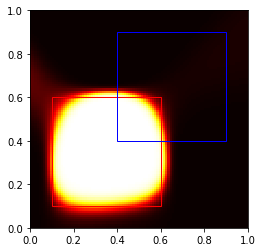

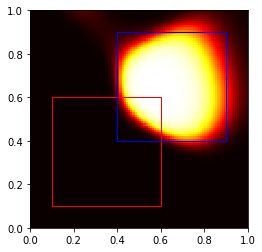

In [13]:
xs = np.arange(0., 1., 0.01, dtype = "float32")
ys = np.arange(0., 1., 0.01, dtype = "float32")
grid = np.array([(x, y) for x in xs for y in ys])
grid = torch.from_numpy(grid)

model.omit_constraints_once()
probs = model(grid)
small = probs[:, 0].reshape(len(xs), len(ys)).detach().numpy()
large = probs[:, 1].reshape(len(xs), len(ys)).detach().numpy()

fig, ax = plt.subplots()
ax.imshow(small, cmap='hot', interpolation='nearest', extent=(0., 1., 0., 1.), origin='lower')
draw_rectangles(ax, rect0, rect1)
plt.show()

fig, ax = plt.subplots()
ax.imshow(large, cmap='hot', interpolation='nearest', extent=(0., 1., 0., 1.), origin='lower')
draw_rectangles(ax, rect0, rect1)
plt.show()

In [14]:
print(small.max())
print(large.max())

1.0
0.99752027
